# Loading the data and packages

In [21]:
using Plots 
using CSV
using Tables
using DataFrames
using GLM
using Measures
plotly()
colors=palette(:seaborn_colorblind)
res = DataFrame(CSV.File("clinicalAndMetricsForUpload.csv"))

Row,Sample,Mutation_spectrum(C>A/C>G/C>T/T>A/T>C/T>G),Mutation_Count(lognumber),Absolute_Ploidy(number),Absolute_Purity(number),Cancer_Type(string),Cancer_Type_Detailed(string),Cluster(number),Cohort(string),Driver_Mutations(number),Number_of_Driver_Structural_Variants(number),Number_of_Samples_Per_Patient(string),Oncotree_Code(string),Sample_Collection_Source(string),Sex(string),Somatic_Status(string),TMB_nonsynonymous(number),Total_Number_of_Nonsilent_Mutation(number),Total_Number_of_Silent_Mutation(number),Total_Rearrangement(number),dbSNP_Mutation_Density(number),Driver_Mutation_Density(number),mean_target_coverage_tumor(number),Mutation_Density(number),Nonsilent_Mutation_Density(number),Number_of_dbSNP_Mutations(number),Number_of_Driver_SCNAs(number),Silent_Mutation_Density(number),Total_CNA(number),Age_at_Diagnosis(number),Age_IPI_Factor(number),CNS_Involvement(string),ECOG_IPI_Score(number),Extralymphatic_Involvement_IPI_Factor(number),IPI(number),LDH_IPI_Factor(number),R-CHOP_like_chemo(string),STAGE_IPI_Factor(number),Testicular_Involvement(string),Overall_Survival_Status(string),Overall_Survival_Months(number),Progress_Free_Survival_Months(number),Progression_Free_Status(string),COO_by_Any_GEP_+_Nanostring(string),Tumor_in_Normal_Estimate(number),Morphology_Subtype(string),COO_by_GEP(string),Consensus_Clustering_Category(string),COO_by_Lymph2CX(string),patientName,peakCN,AUCCN,peakEIA,AUCEIA,peakSyn,AUCSyn,sumOnlyPosSyn,normalisedSyn,logCN
,String31,String31,Int64,Float64,Float64,String31,String,Int64,String15,String3,String3,Int64,String15,String7,String7,String7,Float64,Int64,Int64,String3,String7,String7,Float64,Float64,Float64,String3,String3,Float64,Int64,Int64,String3,String3,String3,String3,String3,String3,String3,String3,String3,String15,Float64,Float64?,String15,String15,String7,String,String15,String7,String15,String31,Int64,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Float64
1,DLBCL-LS951,8/12/40/5/17/9,94,2.21,0.29,Mature_B-Cell_Neoplasms,Germinal_Center_B-Cell_Type,4,Mayo/Iowa,7,N/A,1,GCB,Frozen,Male,Matched,3.13333,94,22,N/A,0.354,0.207,107.0,3.42569,2.77599,12,14,0.65,26,63,1,No,1,N/A,3,N/A,Yes,1,No,DECEASED,1.0,0.7,Progressed,GCB,N/A,N/A,GCB,HR,N/A,DLBCL-LS951,357,647593.0,457,735913.0,55,-88320.0,24778.0,-0.120014,2.55267
2,DLBCL-LS762,4/1/13/1/4/2,28,2.03,0.74,Mature_B-Cell_Neoplasms,"Diffuse_Large_B-Cell_Lymphoma,_NOS",3,Mayo/Iowa,2,N/A,1,DLBCLNOS,Frozen,Female,Matched,0.933333,28,11,1,0.205,0.0585,101.2,1.1414,0.819467,7,2,0.322,15,88,1,No,1,N/A,4,1,No,1,No,DECEASED,3.4,1.2,Progressed,Unclassified,0.005,N/A,Unclassified,BCR,N/A,DLBCL-LS762,331,596705.0,358,568951.0,145,27754.0,49847.0,0.048781,2.51983
3,DLBCL-RICOVER_107,15/6/51/5/15/18,118,2.06,0.4,Mature_B-Cell_Neoplasms,"Diffuse_Large_B-Cell_Lymphoma,_NOS",2,RICOVER,5,1,1,DLBCLNOS,FFPE,Female,Matched,3.93333,118,28,1,0.35,0.159,108.7,4.65025,3.75842,11,20,0.892,54,61,1,No,1,1,5,1,Yes,1,No,DECEASED,4.8296,4.8296,Progressed,Unclassified,0.005,Immunoblastic,N/A,N/A,Unclassified,DLBCL-RICOVER_107,730,1.58e6,568,981483.0,572,596005.0,597398.0,0.607249,2.86332
4,DLBCL-RICOVER_274,10/11/60/4/6/8,103,2.08,0.62,Mature_B-Cell_Neoplasms,Activated_B-cell_Type,4,RICOVER,10,N/A,1,ABC,FFPE,Male,Matched,3.43333,104,38,1,0.85,0.315,109.6,4.47201,3.27528,27,10,1.2,86,78,1,No,N/A,N/A,3,1,Yes,1,No,DECEASED,4.9281,4.9281,Progressed,ABC,0.01,Centroblastic,N/A,N/A,ABC,DLBCL-RICOVER_274,413,746119.0,388,641373.0,250,104746.0,115293.0,0.163315,2.61595
5,DLBCL-LS148,12/3/21/2/8/3,50,2.02,0.95,Mature_B-Cell_Neoplasms,"Diffuse_Large_B-Cell_Lymphoma,_NOS",5,Mayo/Iowa,3,1,1,DLBCLNOS,Frozen,Female,Matched,1.7,51,16,1,0.15,0.0897,88.6,2.00404,1.52547,5,3,0.479,28,82,1,No,N/A,N/A,3,1,Yes,1,No,DECEASED,6.2,5.3,Progressed,N/A,0.01,N/A,N/A,N/A,N/A,DLBCL-LS148,519,878231.0,432,710091.0,300,168140.0,182056.0,0.236787,2.71517
6,DLBCL-RICOVER_181,12/11/59/9/13/16,129,2.39,0.5,Mature_B-Cell_Neoplasms,"Diffuse_Large_B-Cell_Lymphoma,_NOS",1,RICOVER,15,2,1,DLBCLNOS,FFPE,Female,Ma

First we need to calculate the synergy metric as being equal to the peak synergy divided by the peak expected if additive call number

In [22]:
res.synMetric=res.peakSyn./res.peakEIA;

We also need to convert COO to numbers for later plots

In [23]:
res.COONumber=res."COO_by_Any_GEP_+_Nanostring(string)"
res[res.COONumber.=="GCB",:COONumber].=string(1)
res[res.COONumber.=="ABC",:COONumber].=string(2)
res[res.COONumber.=="Unclassified",:COONumber].=string(3)
res[res.COONumber.=="N/A",:COONumber].=string(3)
res.OS=res."Overall_Survival_Months(number)";

In [24]:
# This is the last deceased patient before the first living one
lowOS_res=res[res.OS .< 35, :];

In [25]:
pred_all = DataFrame(OS = 0:1:127);

We need a couple of plotting functions

In [26]:
function plotSyn(OS_col, metric_col, ylabel, n)    
        p = plot(legend=:outertopright,dpi=600)
            plot!(pred.OS, predFrame.prediction, label="model", linewidth=2,color=colors[1])
            plot!(pred.OS, predFrame.prediction, label="model", linewidth=0, color=colors[1],fillalpha=0.3,
                    ribbon = (predFrame.prediction .- predFrame.lower, predFrame.upper .- predFrame.prediction))
            plot!(OS_col, metric_col, label="data", seriestype=:scatter, xlab="Overall survival (months)",
                   ylab=ylabel, color=colors[4],markersize=5,markerstrokewidth=0)
            plot!(legend=false)
            #plot!(yticks=(log10.(collect(range(100,1000,10))),collect(range(100,1000,10))))
            if n == 130
                plot!(xticks=((collect(range(0,130,14))),collect(range(0,130,14))))
            else
                plot!(xticks=((collect(range(0,30,7))),collect(range(0,30,7))))
            end
            plot!(size=(500,500))
            #plot!(left_margin = 10mm)
            plot!(tickfontsize=12, xguidefontsize=18, yguidefontsize=18)
        display(p)
    return(p)
end

plotSyn (generic function with 1 method)

In [27]:
function plotSynCluster(OS_col, metric_col, ylabel, n,colorCol)    
        p = plot(legend=:outertopright,dpi=600)
            plot!(pred.OS, predFrame.prediction, label=false, linewidth=2,color=colors[1])
            plot!(pred.OS, predFrame.prediction, label=false, linewidth=0, color=colors[1],fillalpha=0.3,
                    ribbon = (predFrame.prediction .- predFrame.lower, predFrame.upper .- predFrame.prediction))
            plot!(OS_col, metric_col, label=colorCol, seriestype=:scatter, xlab="Overall survival (months)",
                   ylab=ylabel, color=colorCol,markersize=5,markerstrokewidth=0,palette =colors)
            plot!(legend=false)
            #plot!(yticks=(log10.(collect(range(100,1000,10))),collect(range(100,1000,10))))
            if n == 130
                plot!(xticks=((collect(range(0,130,14))),collect(range(0,130,14))))
            else
                plot!(xticks=((collect(range(0,30,7))),collect(range(0,30,7))))
            end
            plot!(size=(900,500))
            #plot!(left_margin = 10mm)
            plot!(tickfontsize=12, xguidefontsize=18, yguidefontsize=18)
        display(p)
    return(p)
end

plotSynCluster (generic function with 1 method)

## Low overall survival results - synergy metric

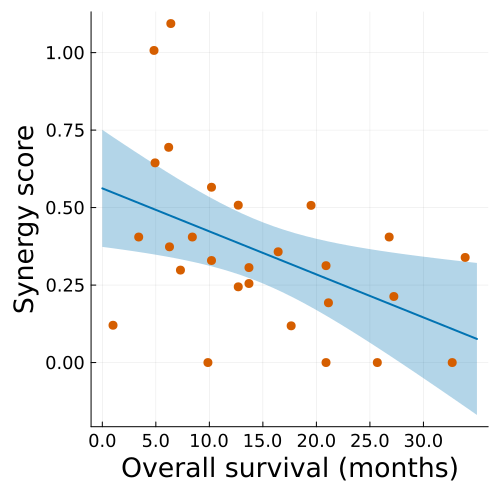

r squared = 0.21216333789438935


"/home/simon/scatterPlot.png"

In [28]:
gr()
pred = DataFrame(OS = 0:1:35);
model = lm(@formula(synMetric ~ OS), lowOS_res)
predFrame = predict(model, pred, level = 0.95,interval = :confidence);
plotSyn(lowOS_res."Overall_Survival_Months(number)", lowOS_res.synMetric, "Synergy score", 30)
println("r squared = "*string(r2(model)))
savefig("scatterPlot.png")

In [29]:
#display a few model properties
model

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

synMetric ~ 1 + OS

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)  Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)   0.562019   0.0916683    6.13    <1e-05   0.373225   0.750813
OS           -0.0138826  0.00535039  -2.59    0.0156  -0.024902  -0.00286332
────────────────────────────────────────────────────────────────────────────

Just reminder of what the key will be for the next plots, where we use the Chapuy et al. clusters.

In [34]:
display(colors[1:5])
println("Cluster: 1,2,3,4,5")

Cluster: 1,2,3,4,5


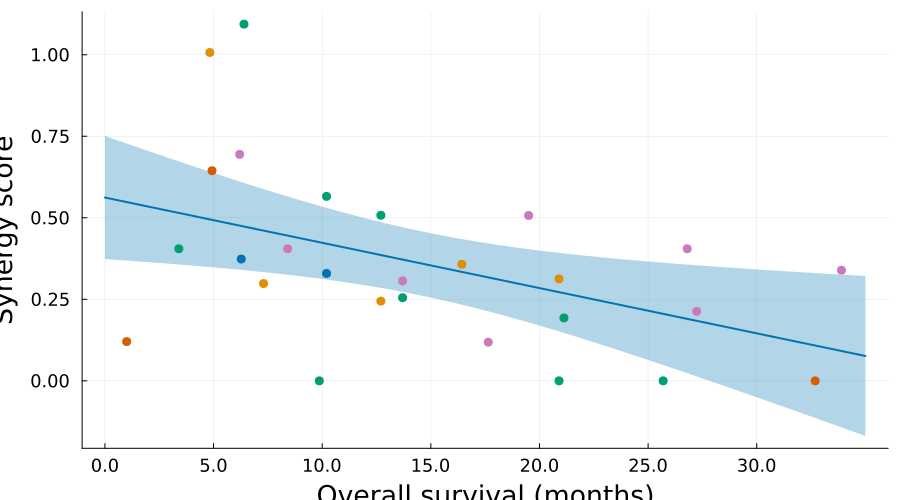

r squared = 0.21216333789438935


"/home/simon/scatterPlotCluster.png"

In [35]:
pred = DataFrame(OS = 0:1:35);
model = lm(@formula(synMetric ~ OS), lowOS_res)
predFrame = predict(model, pred, level = 0.95,interval = :confidence);
plotSynCluster(lowOS_res."Overall_Survival_Months(number)", lowOS_res.synMetric, "Synergy score", 30,lowOS_res."Cluster(number)")
println("r squared = "*string(r2(model)))
savefig("scatterPlotCluster.png")

In [36]:
display(colors[1:3])
println("COO: GCB,ABC,UNC")

COO: GCB,ABC,UNC


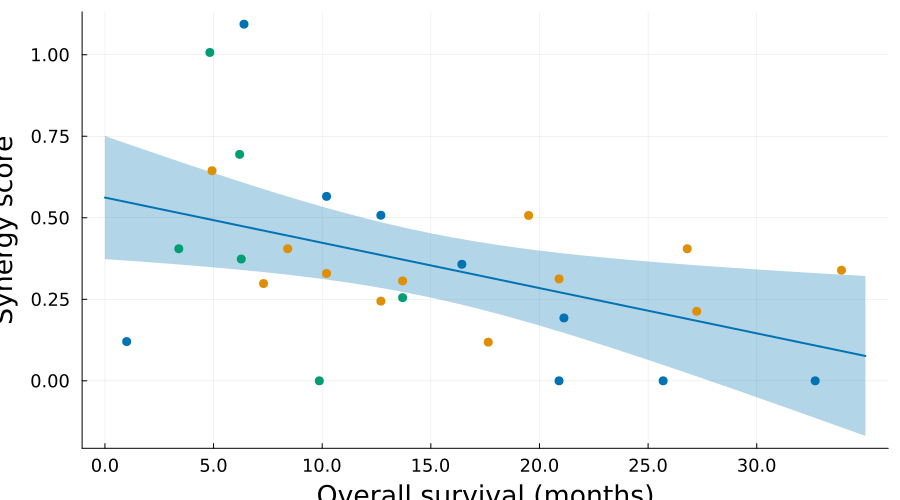

r squared = 0.21216333789438935


"/home/simon/scatterPlotCOO.png"

In [37]:
pred = DataFrame(OS = 0:1:35);
model = lm(@formula(synMetric ~ OS), lowOS_res)
predFrame = predict(model, pred, level = 0.95,interval = :confidence);
plotSynCluster(lowOS_res."Overall_Survival_Months(number)", lowOS_res.synMetric, "Synergy score", 30,parse.(Int64, lowOS_res.COONumber))
println("r squared = "*string(r2(model)))
savefig("scatterPlotCOO.png")

# using peak cell number

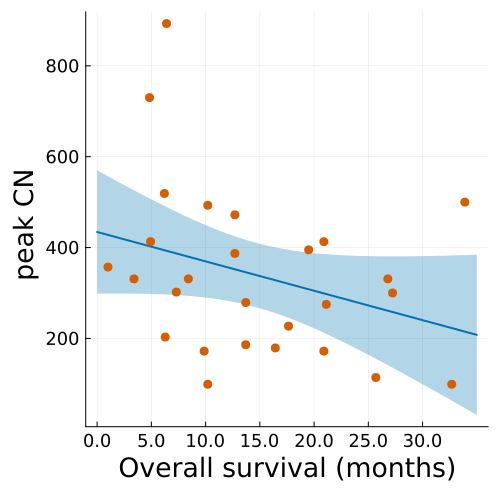

r squared = 0.1016319219650802


"/home/simon/scatterPlotCellNumber.png"

In [38]:
pred = DataFrame(OS = 0:1:35);
model = lm(@formula(peakCN~ OS), lowOS_res)
predFrame = predict(model, pred, level = 0.95,interval = :confidence);
plotSyn(lowOS_res."Overall_Survival_Months(number)", lowOS_res.peakCN, "peak CN ", 30)
println("r squared = "*string(r2(model)))
savefig("scatterPlotCellNumber.png")

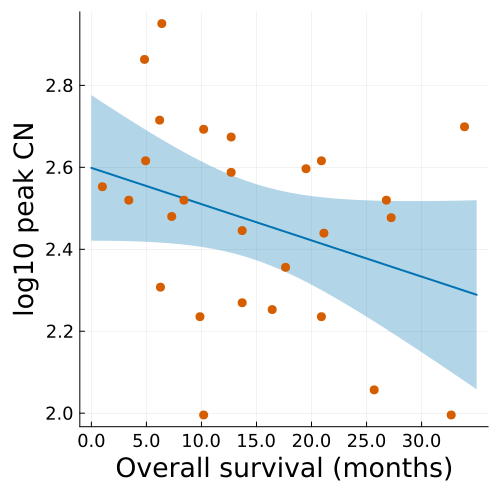

r squared = 0.10994789692322382


In [39]:
lowOS_res.log10peakCN=log10.(lowOS_res.peakCN)
pred = DataFrame(OS = 0:1:35);
model = lm(@formula(log10peakCN~ OS), lowOS_res)
predFrame = predict(model, pred, level = 0.95,interval = :confidence);
plotSyn(lowOS_res."Overall_Survival_Months(number)", lowOS_res.log10peakCN, "log10 peak CN", 30)
println("r squared = "*string(r2(model)))

In [40]:
using Statistics
using StatsPlots
using Query
using HypothesisTests
using Statistics
using DataFrames


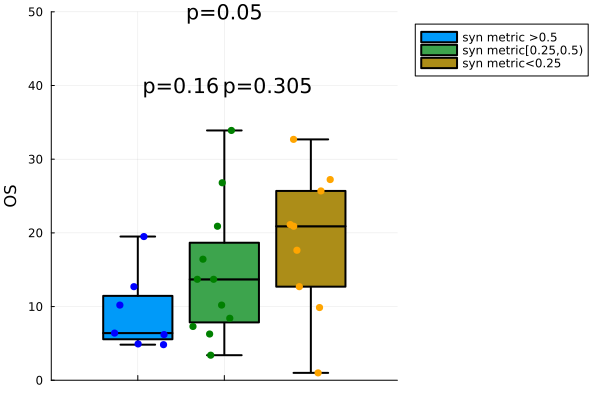

In [41]:
synDF=copy(lowOS_res)
#synDF.newNormSyn=synDF.AUCSyn./synDF.AUCEIA
#synDF=filter(:numMut => n -> n>0,synDF)
#cutoff=median(synDF.OS)*0.7
cutoff=median(synDF.synMetric)
synDF=copy(synDF)
synDF2 = copy(synDF)
synDF3 = copy(synDF)
synDF=filter(:synMetric => n -> n > 0.5, synDF)
synDF2=filter(:synMetric => n -> n > 0.25 && (n<=0.5), synDF2)
synDF3=filter(:synMetric => n -> n <= 0.25, synDF3)



@df synDF boxplot([1], :OS, label="syn metric >0.5",linewidth=2)
#@df singers_moscow violin!(string.(:VoicePart), :Height, side=:left, linewidth=0, label="Moscow")
@df synDF dotplot!([1], :OS, marker=(:blue,stroke(0)), label="",mode = :density)


@df synDF2 boxplot!([2], :OS, label="syn metric[0.25,0.5)",linewidth=2)
#@df singers_moscow violin!(string.(:VoicePart), :Height, side=:left, linewidth=0, label="Moscow")
@df synDF2 dotplot!([2], :OS, marker=(:green,stroke(0)), label="",xlim=(0,4),ylim=(0,40),ylabel="OS",mode = :density)


@df synDF3 boxplot!([3], :OS, label="syn metric<0.25",linewidth=2,outliers = true)
#@df singers_moscow violin!(string.(:VoicePart), :Height, side=:left, linewidth=0, label="Moscow")
@df synDF3 dotplot!([3], :OS, marker=(:orange,stroke(0)), label="",xlim=(0,4),ylim=(0,50),ylabel="OS",mode = :density)

#@df singers_moscow dotplot!(string.(:VoicePart), :Height, side=:left, marker=(:black,stroke(0)), label="")
xticks!([1], [""])
plot!(legend=:outertopright)
#pval=pvalue(ApproximateTwoSampleKSTest(synDF.newNormSyn, synDF2.newNormSyn); tail = :both)
pval=pvalue(MannWhitneyUTest(synDF.OS, synDF2.OS); tail = :both)
annotate!(1.5,40,"p="*string(round(pval,digits=3)))
pval=pvalue(MannWhitneyUTest(synDF2.OS, synDF3.OS); tail = :both)
annotate!(2.5,40,"p="*string(round(pval,digits=3)))
pval=pvalue(MannWhitneyUTest(synDF.OS, synDF3.OS); tail = :both)
annotate!(2,50,"p="*string(round(pval,digits=3)))

xticks!([1,2], [""])

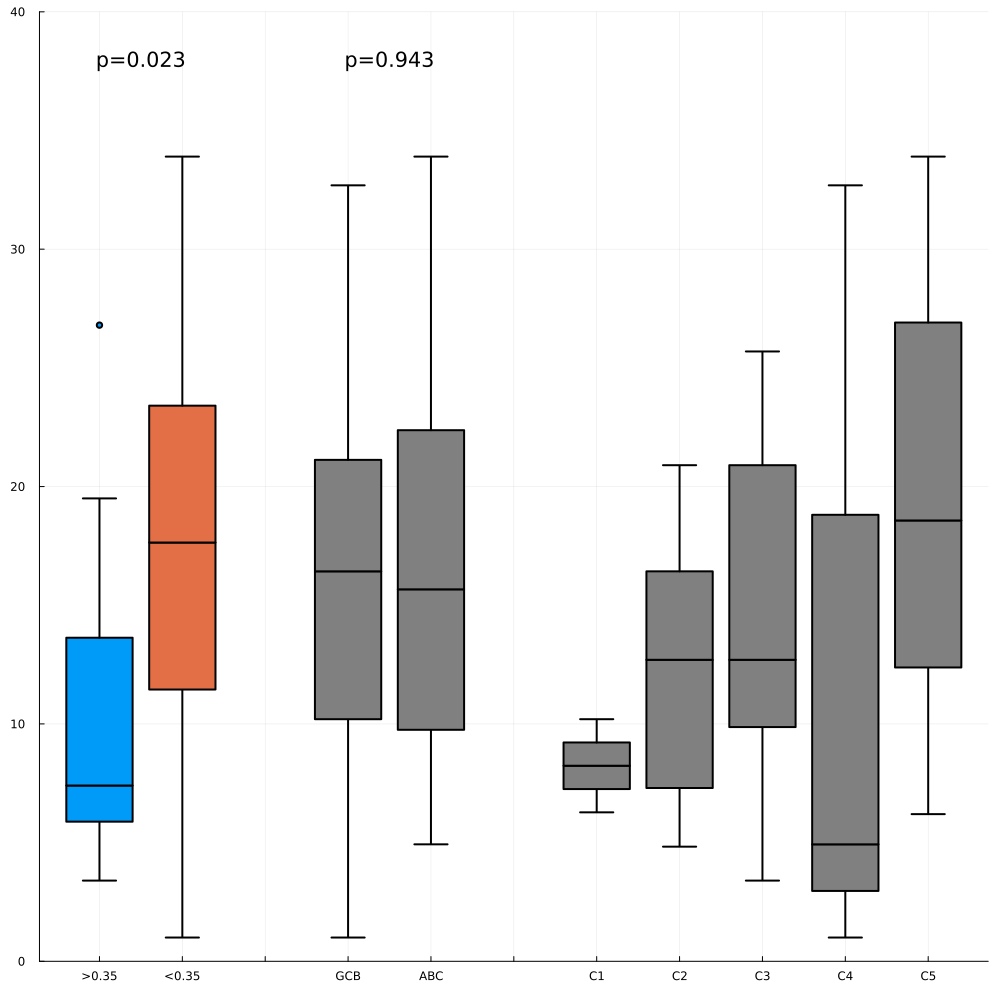

In [45]:
gr()
synDF=copy(lowOS_res)
#synDF.newNormSyn=synDF.AUCSyn./synDF.AUCEIA
#synDF=filter(:numMut => n -> n>0,synDF)
#cutoff=median(synDF.OS)*0.7
cutoff=median(synDF.synMetric)
synDF=copy(synDF)
synDF2 = copy(synDF)
#synDF3 = copy(synDF)
synDF=filter(:synMetric => n -> n > 0.35, synDF)
synDF2=filter(:synMetric => n -> n <= 0.35, synDF2)
#synDF3=filter(:synMetric => n -> n <= 0.25, synDF3)

otherDF=copy(lowOS_res)
otherDF2 = copy(lowOS_res)
otherDF=filter(:COONumber=> n -> n =="1", otherDF)
otherDF2=filter(:COONumber => n -> n =="2", otherDF2)


clusterDF1=copy(lowOS_res)
clusterDF2 = copy(lowOS_res)
clusterDF3 = copy(lowOS_res)
clusterDF4 = copy(lowOS_res)
clusterDF5 = copy(lowOS_res)
clusterDF1=filter("Cluster(number)"=> n -> n ==1, clusterDF1)
clusterDF2=filter("Cluster(number)" => n -> n ==2, clusterDF2)
clusterDF3=filter("Cluster(number)"=> n -> n ==3, clusterDF3)
clusterDF4=filter("Cluster(number)" => n -> n ==4, clusterDF4)
clusterDF5=filter("Cluster(number)" => n -> n ==5, clusterDF5)


@df synDF boxplot([1], :OS, label="syn metric >0.35",linewidth=2,whisker_length=1.5, markersize=3,dpi=600)
#@df singers_moscow violin!(string.(:VoicePart), :Height, side=:left, linewidth=0, label="Moscow")
#@df synDF dotplot!([1], :OS, marker=(:blue,stroke(0)), label="",mode = :density, markersize=3)


@df synDF2 boxplot!([2], :OS, label="syn metri<=0.35",linewidth=2,whisker_length=1.5)
#@df singers_moscow violin!(string.(:VoicePart), :Height, side=:left, linewidth=0, label="Moscow")
#@df synDF2 dotplot!([2], :OS, marker=(:green,stroke(0)), label="",xlim=(0,4),ylim=(0,40),ylabel="OS",mode = :density, markersize=3)


@df otherDF boxplot!([4], :OS, label="GCB",linewidth=2,whisker_length=1.5,color=:gray)
#@df singers_moscow violin!(string.(:VoicePart), :Height, side=:left, linewidth=0, label="Moscow")
#@df otherDF dotplot!([4], :OS, marker=(:black,stroke(0)), marker_size=1,label="",mode = :density, markersize=3)


@df otherDF2 boxplot!([5], :OS, label="ABC",linewidth=2,whisker_length=1.5,color=:gray)
#@df singers_moscow violin!(string.(:VoicePart), :Height, side=:left, linewidth=0, label="Moscow")
#@df otherDF2 dotplot!([5], :OS, marker=(:black,stroke(0)), label="",xlim=(0,6),ylim=(0,40),ylabel="OS",mode = :density,markersize=3)


@df clusterDF1 boxplot!([7], :OS, label="cluster 1",linewidth=2,whisker_length=1.5,color=:gray)
#@df singers_moscow violin!(string.(:VoicePart), :Height, side=:left, linewidth=0, label="Moscow")
#@df clusterDF1 dotplot!([7], :OS, marker=(:black,stroke(0)), label="",mode = :density, markersize=3)

@df clusterDF2 boxplot!([8], :OS, label="cluster 2",linewidth=2,whisker_length=1.5,color=:gray)
#@df singers_moscow violin!(string.(:VoicePart), :Height, side=:left, linewidth=0, label="Moscow")
#@df clusterDF2 dotplot!([8], :OS, marker=(:black,stroke(0)), label="",mode = :density, markersize=3)

@df clusterDF3 boxplot!([9], :OS, label="cluster 3",linewidth=2,whisker_length=1.5,color=:gray)
#@df singers_moscow violin!(string.(:VoicePart), :Height, side=:left, linewidth=0, label="Moscow")
#@df clusterDF3 dotplot!([9], :OS, marker=(:black,stroke(0)), label="",mode = :density, markersize=3)

@df clusterDF4 boxplot!([10], :OS, label="cluster 4",linewidth=2,whisker_length=1.5,color=:gray)
#@df singers_moscow violin!(string.(:VoicePart), :Height, side=:left, linewidth=0, label="Moscow")
#@df clusterDF4 dotplot!([10], :OS, marker=(:black,stroke(0)), label="",mode = :density, markersize=3)

@df clusterDF5 boxplot!([11], :OS, label="cluster 5",linewidth=2,whisker_length=1.5,color=:gray,ylim=(0,40),dpi=600)
#@df singers_moscow violin!(string.(:VoicePart), :Height, side=:left, linewidth=0, label="Moscow")
#@df clusterDF5 dotplot!([11], :OS, marker=(:black,stroke(0)), label="",mode = :density,xlim=(0,12), markersize=3)

# @df synDF3 boxplot!([3], :OS, label="syn metric<0.25",linewidth=2,outliers = true)
# #@df singers_moscow violin!(string.(:VoicePart), :Height, side=:left, linewidth=0, label="Moscow")
# @df synDF3 dotplot!([3], :OS, marker=(:orange,stroke(0)), label="",xlim=(0,4),ylim=(0,50),ylabel="OS",mode = :density)

#@df singers_moscow dotplot!(string.(:VoicePart), :Height, side=:left, marker=(:black,stroke(0)), label="")
xticks!([1], [""])


plot!(legend=false)
#pval=pvalue(ApproximateTwoSampleKSTest(synDF.newNormSyn, synDF2.newNormSyn); tail = :both)
pval=pvalue(MannWhitneyUTest(synDF.OS, synDF2.OS); tail = :both)
annotate!(1.5,38,"p="*string(round(pval,digits=3)))

pval=pvalue(MannWhitneyUTest(otherDF.OS, otherDF2.OS); tail = :both)
annotate!(4.5,38,"p="*string(round(pval,digits=3)))

# pval=pvalue(MannWhitneyUTest(clusterDF1.OS, clusterDF2.OS); tail = :both)
# annotate!(7.5,40,"p="*string(round(pval,digits=3)))
# pval=pvalue(MannWhitneyUTest(clusterDF2.OS, clusterDF3.OS); tail = :both)
# annotate!(8.5,45,"p="*string(round(pval,digits=3)))
# pval=pvalue(MannWhitneyUTest(clusterDF3.OS, clusterDF4.OS); tail = :both)
# annotate!(9.5,40,"p="*string(round(pval,digits=3)))
# pval=pvalue(MannWhitneyUTest(clusterDF4.OS, clusterDF5.OS); tail = :both)
# annotate!(10.5,45,"p="*string(round(pval,digits=3)))
# pval=pvalue(MannWhitneyUTest(clusterDF1.OS, clusterDF3.OS); tail = :both)
# annotate!(8,50,"p="*string(round(pval,digits=3)))
plot!(size=(1000,1000),dpi=600)
savefig("barGraph.png")
xticks!(collect(1:11), [">0.35","<0.35","","GCB","ABC","","C1","C2","C3","C4","C5"])